In [1]:
# basic packages
import pandas as pd
import os
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
warnings.filterwarnings("ignore")

#Shared/Utility scripts
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from model_scripts import Simple_Eval, dataloader, dataprocessor, xgb_model #had to pip install xgboost
HOME = os.path.expanduser('~')

modelname = 'XGBoost'
model_path = f"{HOME}/SWEMLv2.0/Model/{modelname}"
if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)
print(f"{modelname} development script, {device}")

Device: cuda
Device: cuda
XGBoost development script, cuda


In [2]:
#load data
regionlist = ['SouthernRockies', 'Southwest', 'Northwest']
output_res = '300M_Resolution'
DataFrame = 'Sturm_Seasonality_PrecipVIIRSGeoObsDFs'
fSCA_thresh = '20_fSCA_Thresh'

alldata = dataloader.get_ML_Data(regionlist, output_res, DataFrame, fSCA_thresh)
alldata.head()

Concatenating 14 for the model dataframe development.


  0%|          | 0/14 [00:00<?, ?it/s]

There are 305566 datapoints for model training/testing in the SouthernRockies modeling domain.
Concatenating 99 for the model dataframe development.


  0%|          | 0/99 [00:00<?, ?it/s]

There are 2222453 datapoints for model training/testing in the Southwest modeling domain.
Concatenating 2 for the model dataframe development.


  0%|          | 0/2 [00:00<?, ?it/s]

There are 170370 datapoints for model training/testing in the Northwest modeling domain.
There are 2698389 datapoints for model training/testing in the overall modeling domain.


,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,ns_3,...,Seasonal_ns_1_rel,Seasonal_ns_2_rel,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,sturm_value,swe_cm,region,region_class
0,SouthernRockies_300M_37.001_-106.291,2015-04-06,37.001054,-106.290825,2892,24,351,46.2,0.0,31.5,...,0.768849,0.0,0.915969,0.680384,0.755561,0.990386,8,0.000000,SouthernRockies,1
1,SouthernRockies_300M_37.131_-106.329,2015-04-06,37.130654,-106.328625,3069,45,50,46.2,0.0,16.5,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.042090,SouthernRockies,1
2,SouthernRockies_300M_37.131_-106.331,2015-04-06,37.130654,-106.331325,2956,71,58,46.2,0.0,16.5,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.000009,SouthernRockies,1
3,SouthernRockies_300M_37.131_-106.334,2015-04-06,37.130654,-106.334025,2827,62,49,46.2,0.0,16.5,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.000000,SouthernRockies,1
4,SouthernRockies_300M_37.131_-106.337,2015-04-06,37.130654,-106.336725,2746,50,56,46.2,0.0,16.5,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.000000,SouthernRockies,1


## Pull out a test condition by date

In [3]:
# Pulling out 3-29-2019 in Southwest
TestArea = alldata[alldata['Date'] == '2019-03-29']
TestArea.reset_index(inplace=True, drop=True)

#remove Test area data from training/testing dataset
df = pd.concat([alldata, TestArea]).drop_duplicates(keep=False)

# Data Processing

In [4]:
#clean the data
df = dataprocessor.data_clean(df, regionlist)
df.head()

#temporary for seasonality relationship
df.fillna(1, inplace = True)

#convert dates to datetime format
df.Date = pd.to_datetime(df.Date)

input_columns = [
            'cen_lat',	
            'cen_lon',	
            'Elevation_m',	
            'Slope_Deg',	
            'Aspect_Deg',	
            'ns_1',	
            'ns_2',	
            'ns_3',	
            'ns_4',	
            'ns_5',	
            'ns_6',	
            'VIIRS_SCA', 
            'hasSnow',
            'season_precip_cm',
            'region_class',
            'DOS', 
            'WY_week',
            'ns_1_week_mean', 
            'ns_2_week_mean', 
            'ns_3_week_mean', 
            'ns_4_week_mean',
            'ns_5_week_mean', 
            'ns_6_week_mean', 
            'Seasonal_ns_1_rel',
            'Seasonal_ns_2_rel',
            'Seasonal_ns_3_rel', 
            'Seasonal_ns_4_rel',
            'Seasonal_ns_5_rel', 
            'Seasonal_ns_6_rel',
            'sturm_value'
]

years = False
splitratio = 0.33
test_years = [2019]
target = 'swe_cm'

#fit a scaler,save, and scale the training data
x_train, y_train, x_test, y_test = dataprocessor.xgb_processor(
                                                    regionlist,
                                                      df, 
                                                      years, 
                                                      splitratio,
                                                      test_years, 
                                                      target, 
                                                      input_columns, 
                                                      model_path, 
                                                      scalertype = 'MinMax'
                                                      )

The provided data contains 2686699 data points, of which 383243 locations/timesteps show no SWE and VIIRS fsca > 20%
274698 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
150 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
183 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 2028575 datapoints for model training/testing.


,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,ns_3,...,Seasonal_ns_1_rel,Seasonal_ns_2_rel,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,sturm_value,swe_cm,region,region_class
0,SouthernRockies_300M_37.001_-106.291,2015-04-06,37.001054,-106.290825,2892,24,351,46.2,0.0,31.5,...,0.768849,0.0,0.915969,0.680384,0.755561,0.990386,8,0.000000,SouthernRockies,1
1,SouthernRockies_300M_37.131_-106.329,2015-04-06,37.130654,-106.328625,3069,45,50,46.2,0.0,16.5,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.042090,SouthernRockies,1
2,SouthernRockies_300M_37.131_-106.331,2015-04-06,37.130654,-106.331325,2956,71,58,46.2,0.0,16.5,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.000009,SouthernRockies,1
3,SouthernRockies_300M_37.131_-106.334,2015-04-06,37.130654,-106.334025,2827,62,49,46.2,0.0,16.5,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.000000,SouthernRockies,1
4,SouthernRockies_300M_37.131_-106.337,2015-04-06,37.130654,-106.336725,2746,50,56,46.2,0.0,16.5,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.000000,SouthernRockies,1


,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,ns_3,...,Seasonal_ns_1_rel,Seasonal_ns_2_rel,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,sturm_value,swe_cm,region,region_class
248246,Southwest_300M_37.823_-119.291,2013-04-03,37.823104,-119.291404,3074,34,206,21.4,51.1,47.7,...,-0.015389,-0.053034,0.895586,-0.032409,7.149647,-0.076998,8,46.415925,Southwest,2
248247,Southwest_300M_38.074_-119.478,2013-04-03,38.074204,-119.477704,3041,25,147,75.5,113.1,28.4,...,0.791743,0.897023,-0.076998,-0.015389,-0.081448,0.000000,8,75.392413,Southwest,2
248248,Southwest_300M_38.074_-119.48,2013-04-03,38.074204,-119.480404,3154,24,192,75.5,113.1,28.4,...,0.791743,0.897023,-0.076998,-0.015389,-0.081448,0.000000,8,73.140681,Southwest,2
248249,Southwest_300M_38.074_-119.483,2013-04-03,38.074204,-119.483104,3021,27,320,75.5,113.1,28.4,...,0.791743,0.897023,-0.076998,-0.015389,-0.081448,0.000000,8,82.782525,Southwest,2
248250,Southwest_300M_38.074_-119.486,2013-04-03,38.074204,-119.485804,2989,5,22,75.5,113.1,28.4,...,0.791743,0.897023,-0.076998,-0.015389,-0.081448,0.000000,8,72.896212,Southwest,2


,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,ns_3,...,Seasonal_ns_1_rel,Seasonal_ns_2_rel,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,sturm_value,swe_cm,region,region_class
1889677,Northwest_300M_47.496_-123.881,2016-02-08,47.495508,-123.880968,187,12,105,93.0,72.9,56.1,...,1.160310,1.173103,1.323113,1.516877,0.000000,2.260874,8,0.000000,Northwest,3
1889678,Northwest_300M_47.892_-123.622,2016-02-08,47.892408,-123.621767,1684,44,266,72.9,93.0,56.1,...,1.173103,1.160310,1.323113,1.046128,1.516877,2.260874,8,133.371216,Northwest,3
1889679,Northwest_300M_47.892_-123.619,2016-02-08,47.892408,-123.619067,1711,40,315,72.9,93.0,56.1,...,1.173103,1.160310,1.323113,1.046128,1.516877,2.260874,8,93.470695,Northwest,3
1889680,Northwest_300M_47.892_-123.616,2016-02-08,47.892408,-123.616367,1757,11,270,72.9,93.0,56.1,...,1.173103,1.160310,1.323113,1.046128,1.516877,2.260874,8,83.744812,Northwest,3
1889681,Northwest_300M_47.892_-123.614,2016-02-08,47.892408,-123.613667,1864,18,270,72.9,93.0,56.1,...,1.173103,1.160310,1.323113,1.046128,1.516877,2.260874,8,80.450775,Northwest,3


# Train Model

Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 3/3] END eta=0.1, max_depth=8, n_estimators=1000;, score=-5.136 total time=  31.5s
[CV 2/3] END eta=0.1, max_depth=8, n_estimators=1000;, score=-4.140 total time=  32.7s
[CV 1/3] END eta=0.1, max_depth=8, n_estimators=1000;, score=-3.828 total time=  34.0s
[CV 3/3] END eta=0.1, max_depth=10, n_estimators=1000;, score=-5.080 total time=  53.7s
[CV 2/3] END eta=0.1, max_depth=10, n_estimators=1000;, score=-3.989 total time=  58.9s
[CV 1/3] END eta=0.1, max_depth=10, n_estimators=1000;, score=-3.666 total time= 1.0min
[CV 3/3] END eta=0.1, max_depth=12, n_estimators=1000;, score=-5.174 total time= 1.6min
[CV 2/3] END eta=0.1, max_depth=12, n_estimators=1000;, score=-4.016 total time= 1.6min
[CV 1/3] END eta=0.1, max_depth=12, n_estimators=1000;, score=-3.662 total time= 1.7min
Best parameters found: {'eta

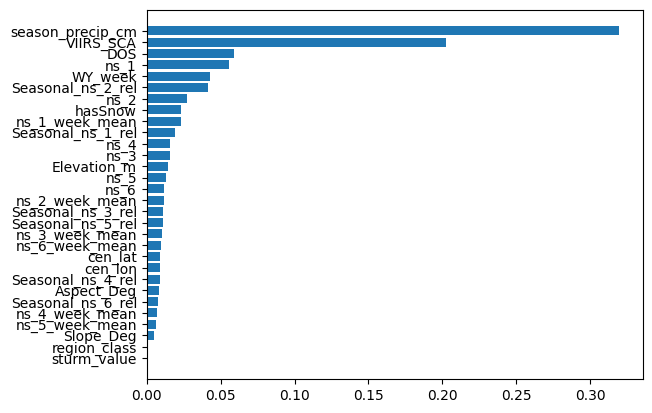

Saving Model
Run is Done!Run Time: 415.41800260543823 seconds 
Model Predictions complete


In [15]:
#Train model
tries = 1 #what is tries?
hyperparameters = {
    'max_depth': [8,10,12], #range (10, 21, 5),
    'n_estimators': [1000], #range(500, 1600, 500),
    'eta': [0.1,]
}
perc_data = 0.25 # percent of training data used to identify optimial hyperparameters

Use_fSCA_Threshold = True

xgb_model.XGB_Train(model_path, 
                    input_columns, 
                    x_train, 
                    y_train, 
                    tries, 
                    hyperparameters,
                    perc_data)

#Make a prediction for each location, save as compressed pkl file, and send predictions to AWS for use in CSES
PredsDF = pd.DataFrame()
PredsDF = xgb_model.XGB_Predict(
                    model_path, 
                    modelname, 
                    x_test,
                    y_test,
                    Use_fSCA_Threshold
                    )

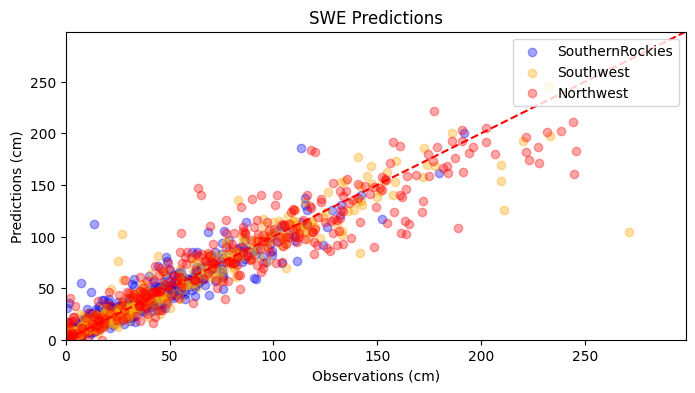

,region,XGBoost_swe_cm_kge,XGBoost_swe_cm_rmse,XGBoost_swe_cm_mape,XGBoost_swe_cm_pbias
0,Overall,0.95,10.0,38.45,-0.35
0,SouthernRockies,0.95,8.0,39.64,-3.20
0,Southwest,0.95,9.0,40.51,0.29
0,Northwest,0.94,12.0,35.20,1.20


In [18]:
#Take a sample to determine model skill - Take 1000 from each modeling domain
n_samples = 1000
SampleDF, PredsDF = Simple_Eval.SamplePreds(regionlist, PredsDF, df, n_samples)


savfig = False
figname = 'Model-Testing-Split-Performance'

 #Evaluate model performance of the different models
prediction_columns = [f"{modelname}_swe_cm"]
Eval_DF = Simple_Eval.Simple_Eval(regionlist,
                                SampleDF,
                                prediction_columns, 
                                modelname, 
                                savfig, 
                                figname,
                                plots = False, 
                                keystats = False        
                                )

In [6]:
Ppath = f"{HOME}/SWEMLv2.0/Predictions/{DataFrame}/{output_res}/{fSCA_thresh}"
if not os.path.exists(Ppath):
    os.makedirs(Ppath, exist_ok=True)


#save the model predictions
table = pa.Table.from_pandas(PredsDF)
# Parquet with Brotli compression
pq.write_table(table, f"{Ppath}/Test_preds.parquet", compression='BROTLI')

## Make a prediction on the held out date


In [ ]:

#Prep prediction data
y_test_Area = pd.DataFrame(TestArea['swe_cm'])
dropcols = ['cell_id',	'Date', 'swe_cm', 'region']
x_test_Area = TestArea.drop(columns=dropcols)
x_test_Area = x_test_Area[input_columns]

#make a prediction
holdoutdate = xgb_model.XGB_Predict(
                    model_path, 
                    modelname, 
                    x_test_Area,
                    y_test_Area,
                    Use_fSCA_Threshold
                    )
#Add geospatial information to prediction DF
EvalDF = pd.concat([TestArea, holdoutdate], axis=1)
#EvalDF.drop(['index'], axis=1, inplace=True)
EvalDF = EvalDF.loc[:,~EvalDF.columns.duplicated()].copy()

EvalDF.head(5)

In [10]:
Ppath = f"{HOME}/SWEMLv2.0/Predictions/{DataFrame}/{output_res}/{fSCA_thresh}"
if not os.path.exists(Ppath):
    os.makedirs(Ppath, exist_ok=True)


#save the model predictions
table = pa.Table.from_pandas(EvalDF)
# Parquet with Brotli compression
pq.write_table(table, f"{Ppath}/All_Feats_HoldOut_03-29-2019.parquet", compression='BROTLI')

In [ ]:
EvalDF.columns

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

from mpl_toolkits.axes_grid1 import make_axes_locatable

def SpatialAnalysis(EvalDF):
    #Convert to a geopandas DF
    Pred_Geo = gpd.GeoDataFrame(EvalDF, geometry = gpd.points_from_xy(EvalDF.cen_lon, EvalDF.cen_lat))

    Pred_Geo.plot(column='Elevation_m',
                  legend=False,
                )
    
SpatialAnalysis(EvalDF)